# Model the El Nino Data

## Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statistics
import math

# sklearn stuff
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import KBinsDiscretizer

# Clustering
from sklearn.cluster import KMeans

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Support Vector Machine
from sklearn.svm import SVC

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

# Random Forests
from sklearn.ensemble import RandomForestClassifier

# Visualize tree
from sklearn import tree
from dtreeviz.trees import dtreeviz
import pydotplus
import os

# Naive Bayes ?
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

##sklearn model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error

## Read Data

In [2]:
# Read the data in which is about 178,000 observations
df = pd.read_csv("elNinoDF.csv")

### Adding wind magnitude

In [3]:
# I think this new variable is relevant
df['wind magnitude'] = round((df['zonal winds']**2 + df['meridional winds']**2) ** 0.5, 2)

## More Visualizations ( Heatmaps )

In [4]:
# Discretize data uniformly
# columns to discretize
cols = ['longitude','date']
data = df[cols]
n = 19
trans = KBinsDiscretizer(n_bins = n, encode = 'ordinal', strategy = 'uniform')
data = trans.fit_transform(data)


temps = np.array(df[['sea temp']])
data = np.hstack((data,temps))
seaTemps = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        temps = data[((data[:,0] == i) | (data[:,1] == j))]
        if len(temps[:,2]) > 0:
            seaTemps[i,j] = statistics.mean(temps[:,2])
        

<AxesSubplot:>

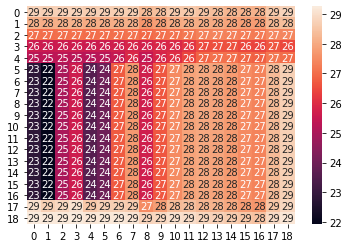

In [5]:
sns.heatmap(seaTemps, annot=True)

In [6]:
# df['longitude'] = np.where(df['longitude'] > 0,df['longitude'] - 180 , df['longitude'] + 180)
df['longitude'] = round(df['longitude']/10)*10
heatData = df[['year', 'longitude', 'sea temp']]
heatData = heatData.groupby(['year', 'longitude']).mean()
# print(heatData)
heatData = heatData.pivot_table(index = 'year', columns = 'longitude', values = 'sea temp')

<AxesSubplot:xlabel='longitude', ylabel='year'>

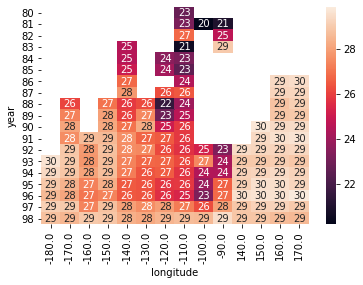

In [7]:
sns.heatmap(heatData, annot=True)

In [8]:
# df['longitude'] = np.where(df['longitude'] > 0,df['longitude'] - 180 , df['longitude'] + 180)
# df['longitude'] = round(df['longitude']/10)*10
heatData = df[['year', 'longitude', 'wind magnitude']]
heatData = heatData.groupby(['year', 'longitude']).mean()
# print(heatData)
heatData = heatData.pivot_table(index = 'year', columns = 'longitude', values = 'wind magnitude')

<AxesSubplot:xlabel='longitude', ylabel='year'>

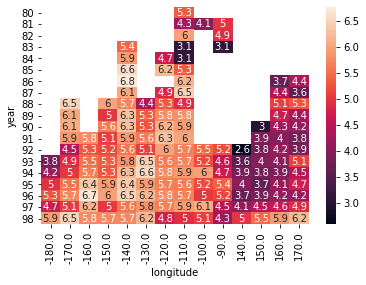

In [9]:
sns.heatmap(heatData, annot=True)

<AxesSubplot:ylabel='Frequency'>

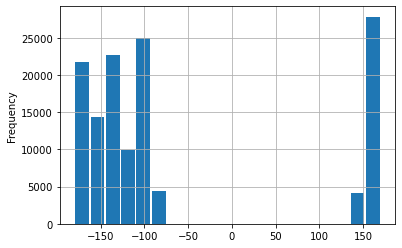

In [10]:

#heatData = df.pivot("longitude", "year", "sea temp")
#heatData
df['longitude'].plot.hist(grid=True, bins=20, rwidth=0.9)

<AxesSubplot:ylabel='Frequency'>

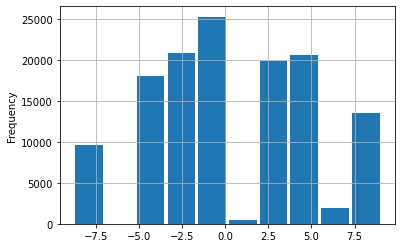

In [100]:
df['latitude'].plot.hist(grid=True, bins=10, rwidth=0.9)

## Preprocessing

In [4]:
df = pd.read_csv("elNinoDF.csv")
df['wind magnitude'] = round((df['zonal winds']**2 + df['meridional winds']**2) ** 0.5, 2)

In [75]:
# do i want to split like this?
# westPac = df[((df["longitude"] < -180.0) | (df["longitude"] > 120))]
# df = df[((df["longitude"] < -180.0) | (df["longitude"] > 120))]
# eastPac = df[((df["longitude"] < -70.0) & (df["longitude"] > -140))]

In [5]:
# columns to preprocess (ie polynomial transform, scale)
polycols = ['zonal winds', 'meridional winds', 'relative humidity','air temp', 'sea temp', 'wind magnitude']
features = df[polycols]

poly = PolynomialFeatures(degree = 1) # degree 1 and 2 are the only sensible options
features = poly.fit_transform(features)


In [6]:
cols = ['date', 'latitude', 'longitude']
features = np.hstack((features, df[cols]))

In [7]:
x = features.copy()
y = df['El Nino'].to_numpy()

In [79]:
print(x)
# so my features are in the order (intercept, zonal winds, meridional winds,
# relative humidity,air temp, sea temp, wind magnitude, date, latitude, longitude)

[[ 1.00000e+00  7.00000e-01  1.20000e+00 ...  9.20426e+05  3.00000e-02
   1.43030e+02]
 [ 1.00000e+00 -6.00000e-01  3.30000e+00 ...  9.20427e+05  3.00000e-02
   1.43040e+02]
 [ 1.00000e+00 -2.10000e+00  4.80000e+00 ...  9.20428e+05  2.00000e-02
   1.43020e+02]
 ...
 [ 1.00000e+00  4.40000e+00 -6.00000e-01 ...  9.80203e+05 -8.03000e+00
   1.64830e+02]
 [ 1.00000e+00  6.90000e+00 -8.00000e-01 ...  9.80204e+05 -8.03000e+00
   1.64820e+02]
 [ 1.00000e+00  3.80000e+00  8.00000e-01 ...  9.80205e+05 -8.03000e+00
   1.64820e+02]]


In [8]:
# scale?
scl = StandardScaler()
x = scl.fit_transform(x)

## Classification

### Regularized Logistic Regression

In [9]:
p = x.shape[1]
## choose grid for regularization parameter
llv = np.linspace(-1,5,100)
lv = np.exp(llv)
Cv = 1/lv
nC = len(Cv)

X = x

rng = np.random.RandomState(45)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=rng, test_size=.2)
lfit = LogisticRegression(penalty='l2')
lfit.fit(Xtrain,ytrain)
yhat = lfit.predict(Xtest)

yhat = yhat.reshape(-1, 1); ytest = ytest.reshape(-1, 1)
lfit.score(Xtest, ytest)


0.9692154153231998

In [9]:
lfit.coef_[0]
# again, features are in the order (intercept, zonal winds, meridional winds,
# relative humidity,air temp, sea temp, wind magnitude, date, latitude, longitude)

array([ 0.        ,  0.28033898,  0.35793888,  0.21117373,  0.78616324,
        0.26785064,  0.16041633,  5.12350982, -0.02851957, -0.27104185])

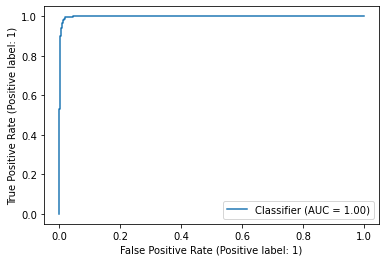

In [10]:
# get the ROC curve
clf = SVC(random_state=rng).fit(Xtrain, ytrain)
yhat = clf.decision_function(Xtest)
RocCurveDisplay.from_predictions(ytest, yhat)

In [11]:
# pip install --upgrade scikit-learn


In [ ]:
iLoss = np.zeros(nC)
oLoss = np.zeros(nC)
# lfit.fit(Xtrain,ytrain)
iLoss[i] = log_loss(ytrain,lfit.predict_proba(Xtrain))
oLoss[i] = log_loss(ytest,lfit.predict_proba(Xtest))


## plot in and out of sample loss
plt.scatter(llv,oLoss,c='blue')
plt.scatter(llv,iLoss,c='red')
plt.xlabel('log(lambda)'); plt.ylabel('deviance loss')

### K Nearest Neighbors

In [83]:
df = pd.read_csv("elNinoDF.csv")
df['wind magnitude'] = round((df['zonal winds']**2 + df['meridional winds']**2) ** 0.5, 2)
cols = ['date', 'latitude', 'longitude', 'zonal winds', 'meridional winds', 'relative humidity',
        'air temp', 'sea temp', 'wind magnitude']
features = df[cols]
y = df['El Nino'].to_numpy()
x = features.copy()

In [84]:
#scale of course
scl = StandardScaler()
x = scl.fit_transform(x)
X = x

Text(0.5, 1.0, 'Which k is best')

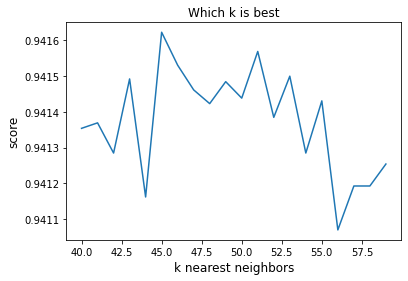

In [94]:
# What k is best?
# will knn do well in 9 dimensions?

kvec = range(40, 60, 1)
scores = np.zeros(len(kvec)) # storage

for i in range(len(kvec)):
    model = KNeighborsClassifier(n_neighbors = kvec[i]) # create the knn model
    score = cross_val_score(model,X,y,cv=5) #cross val with 5 folds
    scores[i] = score.mean() # record the score
    
plt.plot(kvec,scores)
plt.xlabel('k nearest neighbors', size = 'large')
plt.ylabel('score', size = 'large')
plt.title('Which k is best')

In [96]:
np.argmax(scores) + 40
# so k = 45 is the chosen one

45

In [98]:

rng = np.random.RandomState(46)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=rng, test_size=.2)
model = KNeighborsClassifier(n_neighbors = 45, weights = 'distance')
model.fit(Xtrain, ytrain)
yhat = model.predict(Xtest)

yhat = yhat.reshape(-1, 1); ytest = ytest.reshape(-1, 1)
model.score(Xtest, ytest) # within a percentage point of regularized logistic regression

0.9734761246737295

### Trees

In [4]:
df = pd.read_csv("elNinoDF.csv")
df['wind magnitude'] = round((df['zonal winds']**2 + df['meridional winds']**2) ** 0.5, 2)
cols = ['latitude', 'longitude', 'zonal winds', 'meridional winds', 'relative humidity',
        'air temp', 'sea temp', 'wind magnitude']
features = df[cols]
y = df['El Nino'].to_numpy()
X = features.copy()
# no need to scale features with Trees!

In [5]:
rng = np.random.RandomState(47)
rng2 = np.random.RandomState(48)
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state = rng, test_size = .2)
clf = RandomForestClassifier(max_depth = 10, random_state = rng2)
clf.fit(Xtrain, ytrain)
yhat = clf.predict(Xtest)

yhat = yhat.reshape(-1, 1); ytest = ytest.reshape(-1, 1)
clf.score(Xtest, ytest)

0.9076846307385229

In [6]:
ytest.shape

(26052, 1)

In [6]:
### save a tree plot 
### 
clf = RandomForestClassifier(max_depth = 4, random_state = rng2)
clf.fit(Xtrain, ytrain)
estimator = clf.estimators_[6]

dot_data = tree.export_graphviz(estimator,out_file=None,feature_names = cols, class_names = ['No', 'Yes'], filled=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("Ninotree.png") #write graph to file
os.system('eog tree.png') #display file from python command line, unix command eog

32512

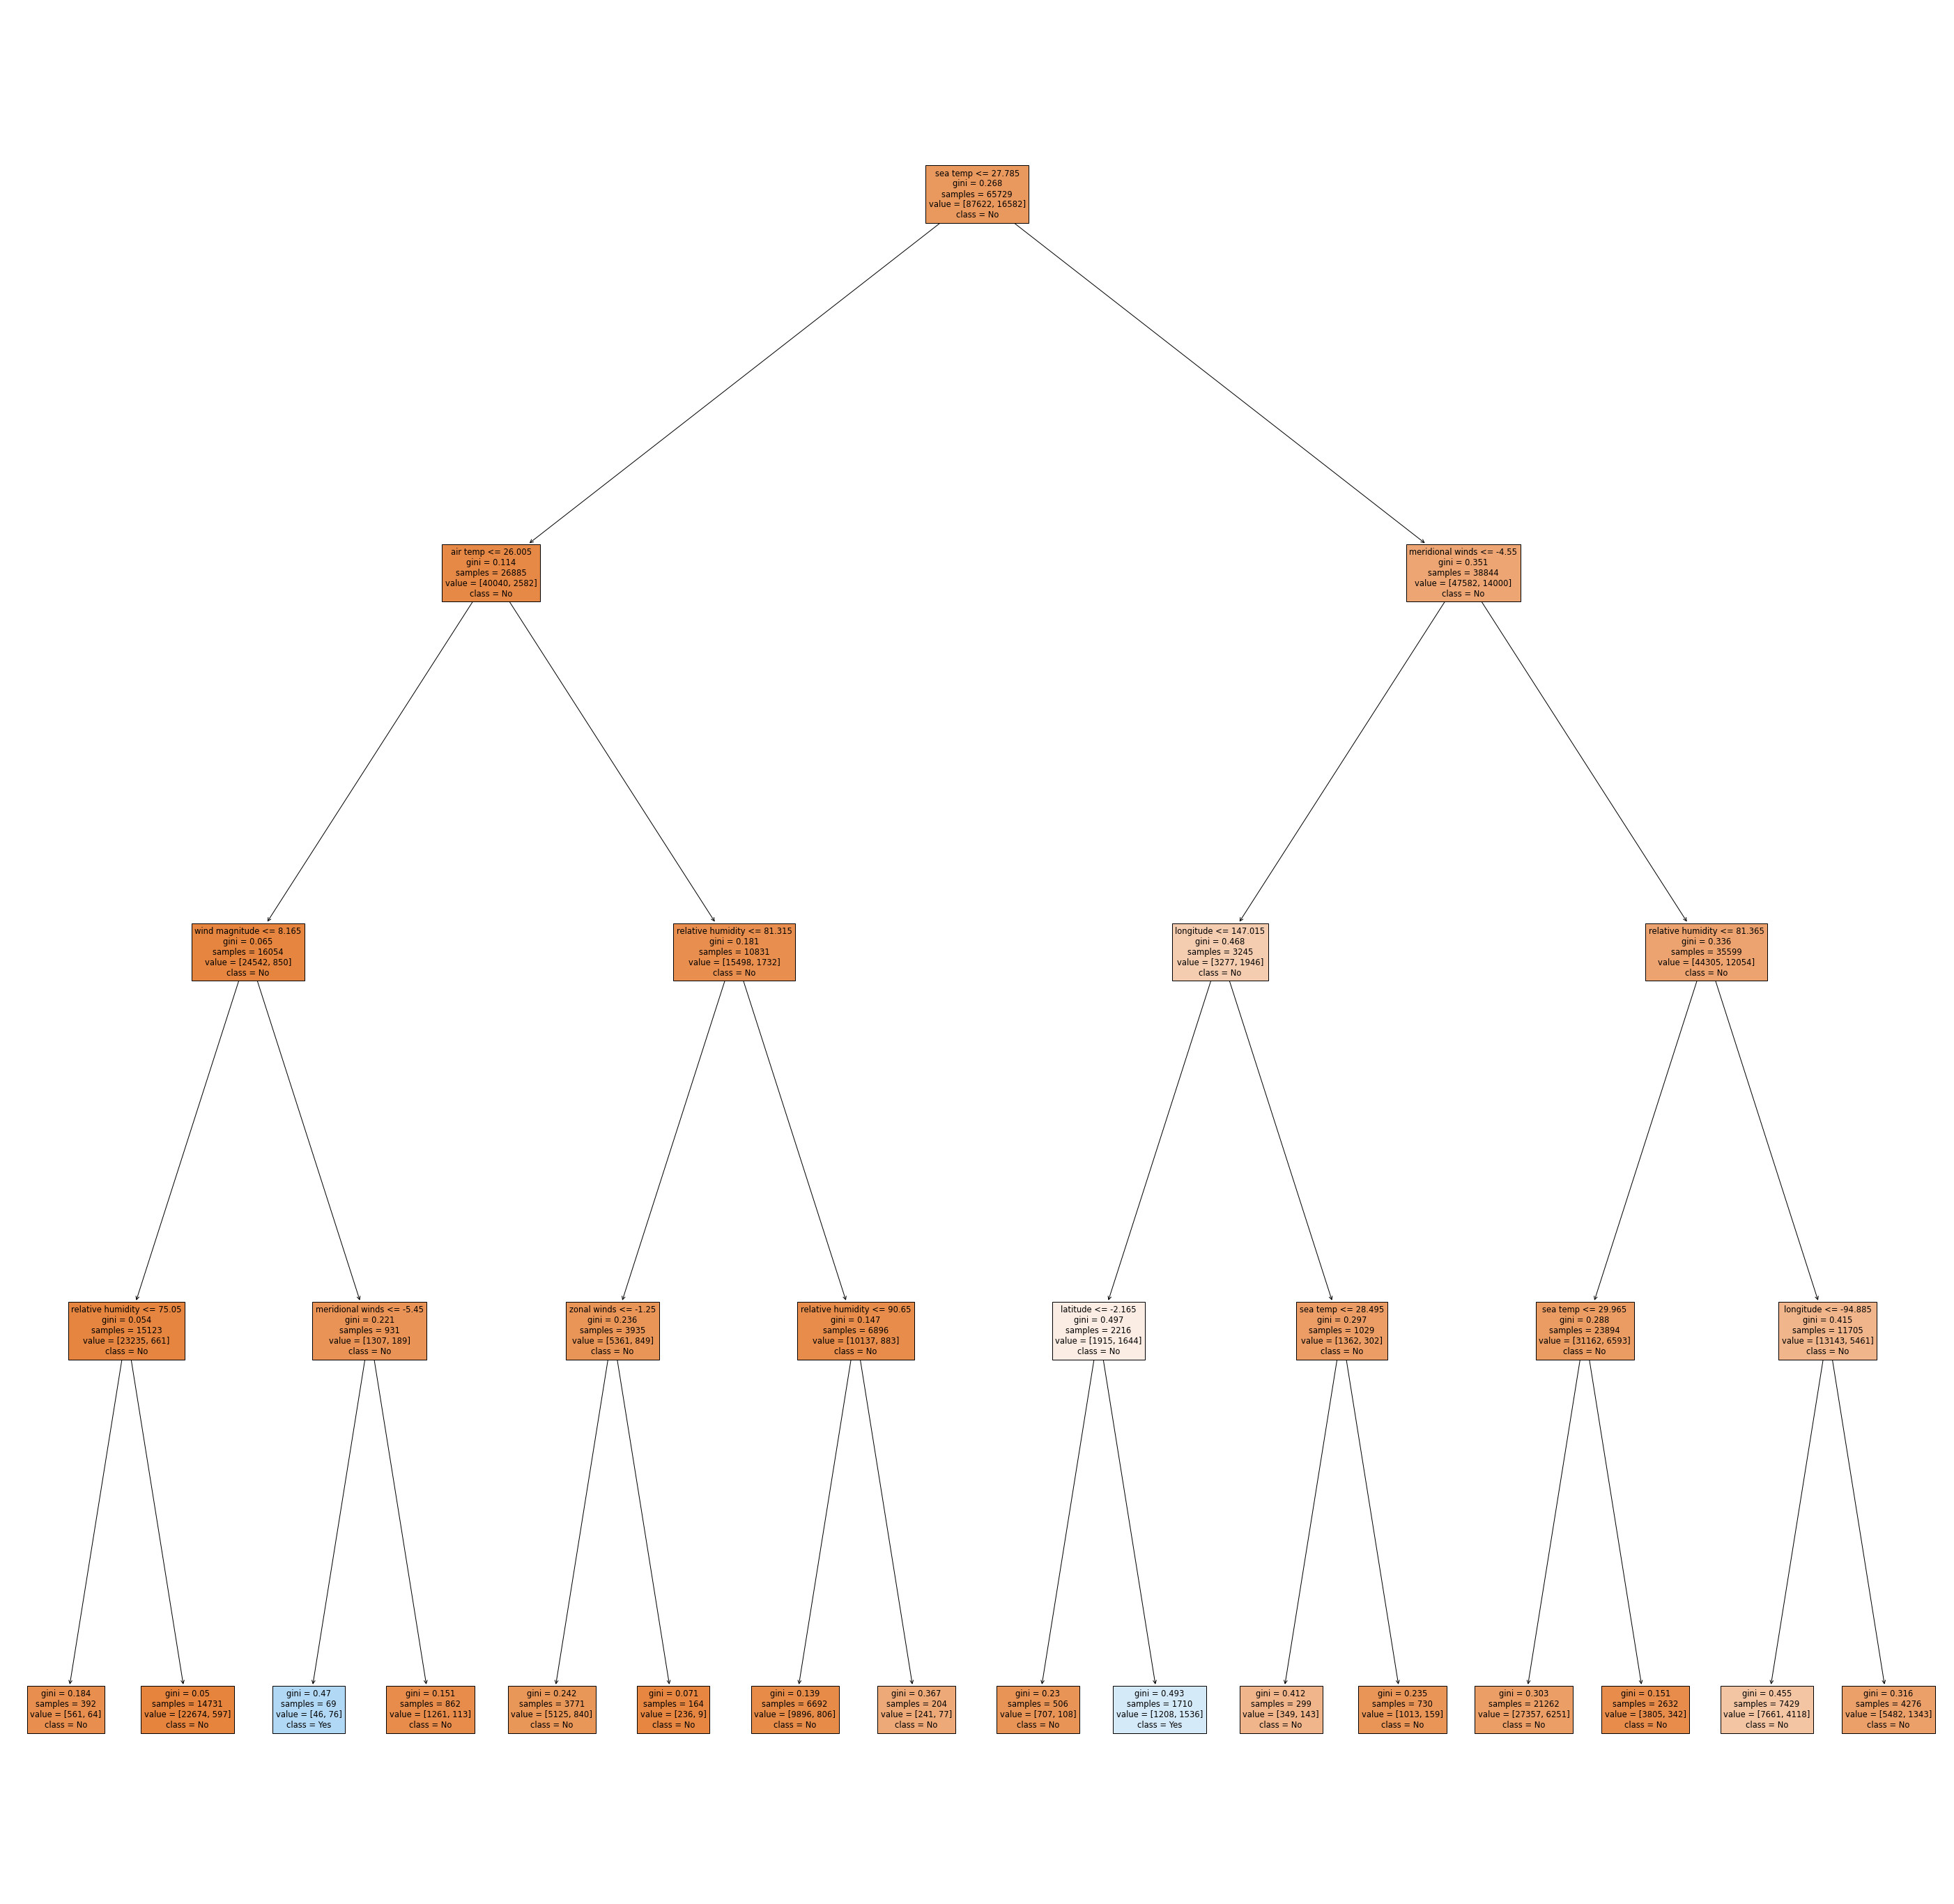

In [7]:
# Visualize the tree
clf = RandomForestClassifier(max_depth = 4, random_state = rng2)
clf.fit(Xtrain, ytrain)
estimator = clf.estimators_[6]

fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(estimator, feature_names = cols, class_names = ['No', 'Yes'], filled=True)
fig.savefig("decision_tree3.png")


In [10]:

#viz = dtreeviz(estimator, Xtrain, ytrain, feature_names = cols, target_name = 'El Nino')
#viz